In [51]:
import h5py
import numpy as np
import keras
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy.special import expit
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.utils import multi_gpu_model
import tensorflow as tf

In [3]:
input_img=Input(shape= (40, 40, 1))
layer=input_img
layer=Conv2D(128, kernel_size=(3, 3),activation='relu',padding='same')(layer)
layer=MaxPooling2D(pool_size=(2, 2),padding='same')(layer)
layer=Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same')(layer)
layer=MaxPooling2D(pool_size=(2, 2),padding='same')(layer)
layer=Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same')(layer)
layer=Flatten()(layer)
layer=Dense(32, activation='relu')(layer)
layer=Dense(6)(layer)
layer=Dense(1)(layer)

model=Model(input_img ,layer)
model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam())
model.summary()
#model.load_weights(".h5")
model.save_weights('cnnbase.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 40, 128)       1280      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 128)       147584    
_________________________________________________________________
flatten_2 (Flatten)          (None, 12800)             0         
__________

In [49]:
f = h5py.File('/pub/daohangt/hep/data/all_118370.h5','r')
ee_x = f['features']['Ecal_E'][:]
et_x = f['features']['Ecal_ET'][:]
he_x = f['features']['Hcal_E'][:]
ht_x = f['features']['Hcal_ET'][:]
print(ee_x.shape)
print(et_x.shape)
print(he_x.shape)
print(ht_x.shape)

(236740, 31, 31)
(236740, 31, 31)
(236740, 32, 32)
(236740, 32, 32)


In [7]:
ee_y = f['targets']['Ecal_E'][:]
et_y = f['targets']['Ecal_ET'][:]
he_y = f['targets']['Hcal_E'][:]
ht_y = f['targets']['Hcal_ET'][:]
print(ee_y.shape)
print(et_y.shape)
print(he_y.shape)
print(ht_y.shape)

(236740,)
(236740,)
(236740,)
(236740,)


In [37]:
# Separate bg/sig for visualizing the jet images
ee_i_bg, ee_i_sig = np.where(ee_y == 0)[0], np.where(ee_y == 1)[0]
ee_x_bg = ee_x[ee_i_bg]
ee_x_sig = ee_x[ee_i_sig]

et_i_bg, et_i_sig = np.where(et_y == 0)[0], np.where(et_y == 1)[0]
et_x_bg = et_x[et_i_bg]
et_x_sig = et_x[et_i_sig]

he_i_bg, he_i_sig = np.where(he_y == 0)[0], np.where(he_y == 1)[0]
he_x_bg = he_x[he_i_bg]
he_x_sig = he_x[he_i_sig]

ht_i_bg, ht_i_sig = np.where(ht_y == 0)[0], np.where(ht_y == 1)[0]
ht_x_bg = ht_x[ht_i_bg]
ht_x_sig = ht_x[ht_i_sig]

In [35]:
# Visualize the bg and sig jet images
def plot2(a,b,vmax,name,ta,tb):
    fig = plt.figure(figsize=(10, 10))
    row,col=1,2
    ax1 = fig.add_subplot(row,col,1)
    plt.imshow(a,cmap='Blues',vmin=-10,vmax=vmax)
    ax2 = fig.add_subplot(row,col,2)
    plt.imshow(b,cmap='Reds',vmin=-10,vmax=vmax)
    #plt.show()
    ax1.title.set_text(ta)
    ax2.title.set_text(tb)
    plt.savefig(name)
    
def plot2_nAgg(s,e,xbg,xsig,vmax,name,ta,tb):
    if len(xbg.shape) == 3:
        xbgg = np.copy(xbg[0])
        xsigg = np.copy(xsig[0])
        for i in range(s,e):
            xbgg += xbg[i]
            xsigg += xsig[i]
    else:
        xbgg = np.copy(xbg[0][0])
        xsigg = np.copy(xsig[0][0])
        for i in range(s,e):
            xbgg += xbg[i][0]
            xsigg += xsig[i][0]
    plot2(xbgg,xsigg,vmax,name,ta,tb)

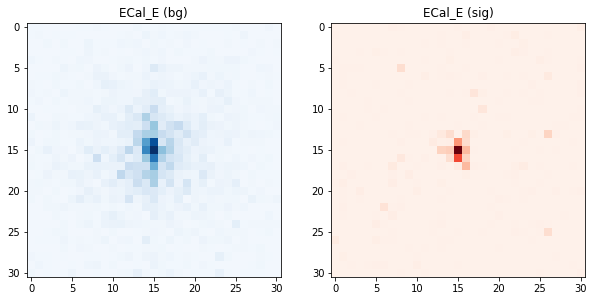

In [36]:
plot2_nAgg(0,1000,ee_x_bg,ee_x_sig,400,"ee.png",'ECal_E (bg)','ECal_E (sig)')

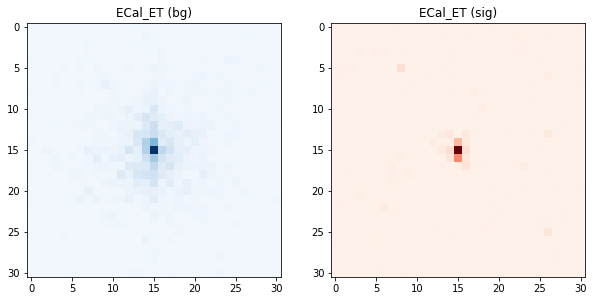

In [39]:
plot2_nAgg(0,1000,et_x_bg,et_x_sig,400,"et.png",'ECal_ET (bg)','ECal_ET (sig)')

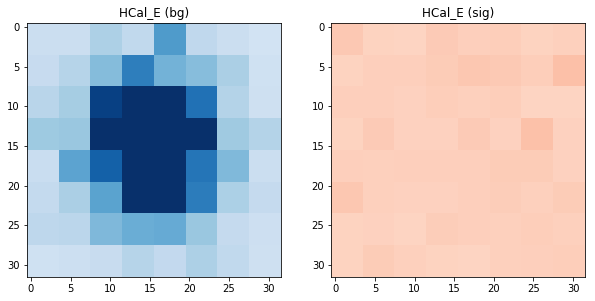

In [44]:
plot2_nAgg(0,1000,he_x_bg,he_x_sig,50,"he.png",'HCal_E (bg)','HCal_E (sig)')

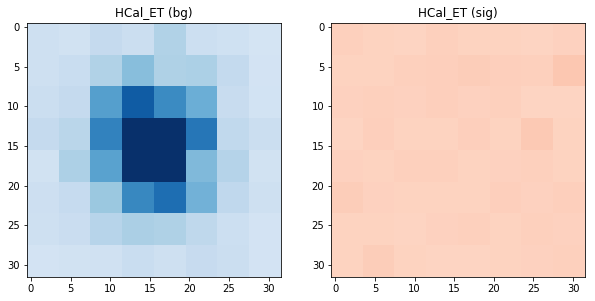

In [45]:
plot2_nAgg(0,1000,ht_x_bg,ht_x_sig,50,"ht.png",'HCal_ET (bg)','HCal_ET (sig)')

In [50]:
print("Before massaging: ")
print(ee_x.shape)
print(et_x.shape)
print(he_x.shape)
print(ht_x.shape)

def pad(x):
    if x.shape[-1] == 32:
        return np.pad(x,((0,0),(4,4),(4,4)), 'constant')
    else:
        # 31*31
        return np.pad(x,((0,0),(4,5),(4,5)), 'constant')

def extra(x):
    sz = x.shape+(1,)
    x = np.resize(x, tuple(i for i in sz))
    return x

# Massage the data: padding + extra1
ee_x = extra(pad(ee_x))
et_x = extra(pad(et_x))
he_x = extra(pad(he_x))
ht_x = extra(pad(ht_x))

print("After massaging: ")
print(ee_x.shape)
print(et_x.shape)
print(he_x.shape)
print(ht_x.shape)

Before massaging: 
(236740, 31, 31)
(236740, 31, 31)
(236740, 32, 32)
(236740, 32, 32)
After massaging: 
(236740, 40, 40, 1)
(236740, 40, 40, 1)
(236740, 40, 40, 1)
(236740, 40, 40, 1)


In [52]:
# Splitting train & validation
ee_x_tr, ee_x_val, ee_y_tr, ee_y_val = train_test_split(ee_x, ee_y, test_size=0.20, random_state=42)
et_x_tr, et_x_val, et_y_tr, et_y_val = train_test_split(et_x, et_y, test_size=0.20, random_state=42)
he_x_tr, he_x_val, he_y_tr, he_y_val = train_test_split(he_x, he_y, test_size=0.20, random_state=42)
ht_x_tr, ht_x_val, ht_y_tr, ht_y_val = train_test_split(ht_x, ht_y, test_size=0.20, random_state=42)

In [54]:
# Final check for the shape
def printShape(x):
    for i in x:
        print(i.shape)
        
printShape((ee_x_tr, ee_x_val, ee_y_tr, ee_y_val)) 
printShape((et_x_tr, et_x_val, et_y_tr, et_y_val))
printShape((he_x_tr, he_x_val, he_y_tr, he_y_val))
printShape((ht_x_tr, ht_x_val, ht_y_tr, ht_y_val))

(189392, 40, 40, 1)
(47348, 40, 40, 1)
(189392,)
(47348,)
(189392, 40, 40, 1)
(47348, 40, 40, 1)
(189392,)
(47348,)
(189392, 40, 40, 1)
(47348, 40, 40, 1)
(189392,)
(47348,)
(189392, 40, 40, 1)
(47348, 40, 40, 1)
(189392,)
(47348,)


In [55]:
model.load_weights('cnnbase.h5')
callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, 
                                           patience=10, verbose=0,
                                           mode='auto', baseline=None,
                                           restore_best_weights=True)]

history_ee = model.fit(ee_x_tr, ee_y_tr, epochs=20, batch_size=128,
                validation_data=(ee_x_val,ee_y_val),verbose=1,
                callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Train on 189392 samples, validate on 47348 samples
Epoch 1/20
189392/189392 [==============================] - 36s 193us/step - loss: 0.1274 - val_loss: 0.0235
Epoch 2/20
189392/189392 [==============================] - 30s 157us/step - loss: 0.0249 - val_loss: 0.0241
Epoch 3/20
189392/189392 [==============================] - 30s 157us/step - loss: 0.0224 - val_loss: 0.0205
Epoch 4/20
189392/189392 [==============================] - 30s 157us/step - loss: 0.0206 - val_loss: 0.0200
Epoch 5/20
189392/189392 [==============================] - 30s 157us/step - loss: 0.0202 - val_loss: 0.0192
Epoch 6/20
189392/189392 [==============================] - 30s 158us/step - loss: 0.0202 - val_loss: 0.0204
Epoch 7/20
189392/189392 [==============================] - 30s 158us/step - loss: 0.0196 - val_loss: 0.0204
Epoch 8/20
189392/189392 [==============================] - 30s 158us/step - loss: 0.0197 - val_loss: 0.0200
Epoch 9/20
189392/189392 [===

In [56]:
model.save_weights('cnnbase_ee_20e_128b.h5')

In [64]:
def plot_al(history,aorl,t):
    plt.plot(history.history[aorl])
    plt.plot(history.history['val_'+aorl])
    plt.title(t + (" Accuracy" if aorl=="acc" else " Loss"))
    plt.ylabel(aorl)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

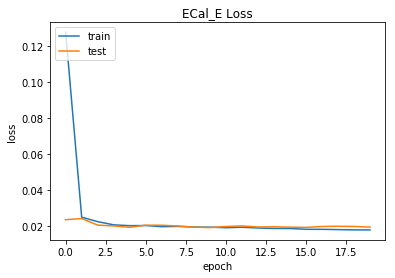

In [65]:
plot_al(history_ee,'loss', 'ECal_E')

In [66]:
model.load_weights('cnnbase.h5')
history_et = model.fit(et_x_tr, et_y_tr, epochs=20, batch_size=128,
                validation_data=(et_x_val,et_y_val),verbose=1,
                callbacks=callbacks)

Train on 189392 samples, validate on 47348 samples
Epoch 1/20
189392/189392 [==============================] - 30s 157us/step - loss: 0.3593 - val_loss: 0.0125
Epoch 2/20
189392/189392 [==============================] - 30s 157us/step - loss: 0.0121 - val_loss: 0.0120
Epoch 3/20
189392/189392 [==============================] - 30s 157us/step - loss: 0.0112 - val_loss: 0.0118
Epoch 4/20
189392/189392 [==============================] - 30s 158us/step - loss: 0.0110 - val_loss: 0.0109
Epoch 5/20
189392/189392 [==============================] - 30s 158us/step - loss: 0.0109 - val_loss: 0.0108
Epoch 6/20
189392/189392 [==============================] - 30s 158us/step - loss: 0.0107 - val_loss: 0.0109
Epoch 7/20
189392/189392 [==============================] - 30s 158us/step - loss: 0.0106 - val_loss: 0.0106
Epoch 8/20
189392/189392 [==============================] - 30s 158us/step - loss: 0.0106 - val_loss: 0.0104
Epoch 9/20
189392/189392 [==============================] - 30s 158us/step - 

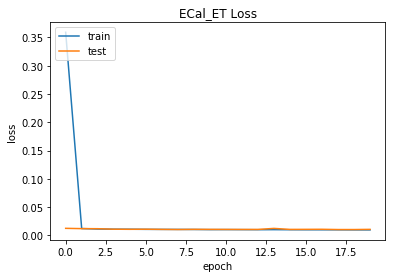

In [75]:
plot_al(history_et,'loss', 'ECal_ET')

In [67]:
model.save_weights('cnnbase_et_20e_128b.h5')

In [72]:
model.load_weights('cnnbase.h5')
history_he = model.fit(he_x_tr, he_y_tr, epochs=20, batch_size=128, 
                validation_data=(he_x_val,he_y_val),verbose=1,
                callbacks=callbacks)
model.save_weights('cnnbase_he_20e_128b.h5')

Train on 189392 samples, validate on 47348 samples
Epoch 1/20
189392/189392 [==============================] - 30s 157us/step - loss: 0.1167 - val_loss: 0.1128
Epoch 2/20
189392/189392 [==============================] - 30s 157us/step - loss: 0.1132 - val_loss: 0.1120
Epoch 3/20
189392/189392 [==============================] - 30s 158us/step - loss: 0.1129 - val_loss: 0.1121
Epoch 4/20
189392/189392 [==============================] - 30s 157us/step - loss: 0.1128 - val_loss: 0.1125
Epoch 5/20
189392/189392 [==============================] - 30s 158us/step - loss: 0.1127 - val_loss: 0.1140
Epoch 6/20
189392/189392 [==============================] - 30s 158us/step - loss: 0.1125 - val_loss: 0.1121
Epoch 7/20
189392/189392 [==============================] - 30s 158us/step - loss: 0.1125 - val_loss: 0.1121
Epoch 8/20
189392/189392 [==============================] - 30s 158us/step - loss: 0.1123 - val_loss: 0.1123
Epoch 9/20
189392/189392 [==============================] - 30s 158us/step - 

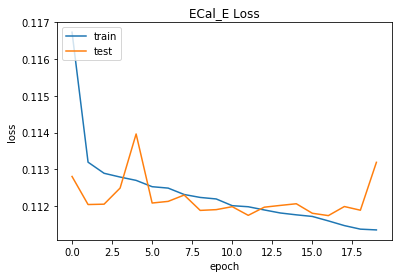

In [76]:
plot_al(history_he,'loss', 'ECal_E')

In [73]:
model.load_weights('cnnbase.h5')
history_ht = model.fit(ht_x_tr, ht_y_tr, epochs=20, batch_size=128,
                validation_data=(ht_x_val,ht_y_val),verbose=1,
                callbacks=callbacks)
model.save_weights('cnnbase_ht_20e_128b.h5')

Train on 189392 samples, validate on 47348 samples
Epoch 1/20
189392/189392 [==============================] - 30s 159us/step - loss: 0.1125 - val_loss: 0.1088
Epoch 2/20
189392/189392 [==============================] - 30s 158us/step - loss: 0.1092 - val_loss: 0.1097
Epoch 3/20
189392/189392 [==============================] - 30s 158us/step - loss: 0.1090 - val_loss: 0.1081
Epoch 4/20
189392/189392 [==============================] - 30s 159us/step - loss: 0.1088 - val_loss: 0.1080
Epoch 5/20
189392/189392 [==============================] - 30s 159us/step - loss: 0.1090 - val_loss: 0.1082
Epoch 6/20
189392/189392 [==============================] - 30s 158us/step - loss: 0.1089 - val_loss: 0.1082
Epoch 7/20
189392/189392 [==============================] - 30s 159us/step - loss: 0.1088 - val_loss: 0.1091
Epoch 8/20
189392/189392 [==============================] - 30s 159us/step - loss: 0.1087 - val_loss: 0.1085
Epoch 9/20
189392/189392 [==============================] - 30s 159us/step - 

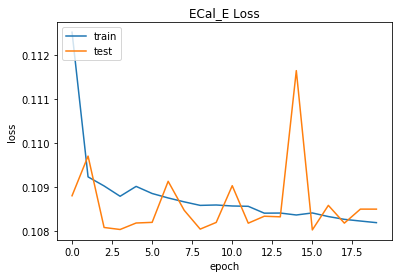

In [77]:
plot_al(history_ht,'loss', 'ECal_E')